# Notebook to test the scOPE code

Andrew Ashford, Pathways + Omics Group, OHSU
5/20/2024

This workflow will use bulk RNA-seq counts and variant call data to train logistic ridge regression classifiers to predict the presence or absence of cancer-associated mutations. I will then apply the models to single-cell data and perform additional experiments to determine clonal structures. This notebook is meant to implement and debug/test the code for this workflow as I write it.

In [1]:
# Import modules
import sys
import pandas as pd
import numpy as np

# Import custom modules
sys.path.append('../')
from scOPE import preprocessing
from scOPE import utilities
from scOPE import models
from scOPE import evaluate


## Training classification models using bulk RNA-seq data

#### Read and preprocess data

In [2]:
# Specify directory and filename of Variant Call File (VCF)
#vcf_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/'
vcf_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/publicly_available_and_raw_counts/'

#vcf_filename = 'beataml_wes_wv1to4_mutations_v4_exon_mut_loc_and_variant_class_added.tsv'
vcf_filename = 'beataml_wes_wv1to4_mutations_dbgap.txt'


In [3]:
# Read VCF file into a Pandas dataframe with this preprocessing function
# NOTE: This function defaults to delimiter='\t', to change this, add a delimiter= flag and specify delimiter
vcf_df = preprocessing.tsv_to_df(vcf_dir + vcf_filename)


In [4]:
# Sanity check the dataframe of the tsv file
print(vcf_df)


      dbgap_sample_id              capture_type seqnames  pos_start  \
0             BA2336D               NexteraV1.2        4  106156042   
1             BA2336D               NexteraV1.2        4  106190829   
2             BA2336D               NexteraV1.2        5  170837543   
3             BA2643D               NexteraV1.2       11   32456651   
4             BA2643D               NexteraV1.2        2   25457242   
...               ...                       ...      ...        ...   
11716         BA3100D  Nimblegen Custom Capture        2   25457242   
11717         BA3100D  Nimblegen Custom Capture        2   25457242   
11718         BA3100D  Nimblegen Custom Capture        5  170837543   
11719         BA3100D  Nimblegen Custom Capture        1  115258747   
11720         BA3100D  Nimblegen Custom Capture        1  115258747   

         pos_end ref    alt genotyper  tumor_only  total_reads  ...  \
0      106156043  TC      T   varscan           1          151  ...   
1    

In [5]:
# Eliminate sex chromosomes
# Filter out rows where 'seqnames' is 'X' or 'Y'
vcf_df = vcf_df[~vcf_df['seqnames'].isin(['X', 'Y'])]


In [6]:
# Display the filtered DataFrame
print(vcf_df)


      dbgap_sample_id              capture_type seqnames  pos_start  \
0             BA2336D               NexteraV1.2        4  106156042   
1             BA2336D               NexteraV1.2        4  106190829   
2             BA2336D               NexteraV1.2        5  170837543   
3             BA2643D               NexteraV1.2       11   32456651   
4             BA2643D               NexteraV1.2        2   25457242   
...               ...                       ...      ...        ...   
11716         BA3100D  Nimblegen Custom Capture        2   25457242   
11717         BA3100D  Nimblegen Custom Capture        2   25457242   
11718         BA3100D  Nimblegen Custom Capture        5  170837543   
11719         BA3100D  Nimblegen Custom Capture        1  115258747   
11720         BA3100D  Nimblegen Custom Capture        1  115258747   

         pos_end ref    alt genotyper  tumor_only  total_reads  ...  \
0      106156043  TC      T   varscan           1          151  ...   
1    

In [7]:
# How to access ensembl gene ID
#print(vcf_df['gene'])

# How to access gene by name
#print(vcf_df['symbol'])


0          TET2
1          TET2
2          NPM1
3           WT1
4        DNMT3A
          ...  
11716    DNMT3A
11717    DNMT3A
11718      NPM1
11719      NRAS
11720      NRAS
Name: symbol, Length: 11080, dtype: object


In [26]:
# Filter out the rows where the "polyphen" column doesn't contain the word "damaging"
#vcf_df = vcf_df[vcf_df['polyphen'].str.contains('damaging', na=False)]
#vcf_df = vcf_df[vcf_df['existing_variation'].str.contains('COSM', na=False)]


In [8]:
# Display the filtered DataFrame
print(vcf_df)


      dbgap_sample_id              capture_type seqnames  pos_start  \
0             BA2336D               NexteraV1.2        4  106156042   
1             BA2336D               NexteraV1.2        4  106190829   
2             BA2336D               NexteraV1.2        5  170837543   
3             BA2643D               NexteraV1.2       11   32456651   
4             BA2643D               NexteraV1.2        2   25457242   
...               ...                       ...      ...        ...   
11716         BA3100D  Nimblegen Custom Capture        2   25457242   
11717         BA3100D  Nimblegen Custom Capture        2   25457242   
11718         BA3100D  Nimblegen Custom Capture        5  170837543   
11719         BA3100D  Nimblegen Custom Capture        1  115258747   
11720         BA3100D  Nimblegen Custom Capture        1  115258747   

         pos_end ref    alt genotyper  tumor_only  total_reads  ...  \
0      106156043  TC      T   varscan           1          151  ...   
1    

In [43]:
# Specify directory and filename of the RNA-seq counts file
#counts_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/'
counts_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/publicly_available_and_raw_counts/'

#counts_filename = 'beataml_waves1to4_norm_transposed.tsv'
#counts_filename = 'beataml_waves1to4_norm.tsv'
counts_filename = 'beataml_waves1to4_counts_dbgap.txt'


In [44]:
# Read RNA-seq counts TSV file into a Pandas dataframe with this preprocessing function
# NOTE: This function defaults to delimiter='\t', to change this, add a delimiter= flag and specify delimiter
counts_df = preprocessing.tsv_to_df(counts_dir + counts_filename, index_col = 0)


In [45]:
# Print DF as a sanity check
print(counts_df)

                 display_label  \
stable_id                        
ENSG00000000003         TSPAN6   
ENSG00000000005           TNMD   
ENSG00000000419           DPM1   
ENSG00000000457          SCYL3   
ENSG00000000460       C1orf112   
...                        ...   
ENSG00000273489  RP11-180C16.1   
ENSG00000273490         TSEN34   
ENSG00000273491   RP11-138A9.2   
ENSG00000273492     AP000230.1   
ENSG00000273493   RP11-80H18.4   

                                                       description  \
stable_id                                                            
ENSG00000000003       tetraspanin 6 [Source:HGNC Symbol;Acc:11858]   
ENSG00000000005         tenomodulin [Source:HGNC Symbol;Acc:17757]   
ENSG00000000419  dolichyl-phosphate mannosyltransferase polypep...   
ENSG00000000457  SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...   
ENSG00000000460  chromosome 1 open reading frame 112 [Source:HG...   
...                                                            ... 

In [46]:
print(set(counts_df['biotype']))


{'IG_V_pseudogene', 'IG_J_pseudogene', 'TR_J_pseudogene', 'lincRNA', 'protein_coding', 'IG_D_gene', 'processed_pseudogene', 'processed_transcript', 'TR_V_pseudogene', 'TR_V_gene', 'sense_overlapping', 'IG_V_gene', '3prime_overlapping_ncrna', 'pseudogene', 'sense_intronic', 'IG_C_gene', 'misc_RNA', 'polymorphic_pseudogene', 'Mt_tRNA', 'TR_D_gene', 'TR_J_gene', 'TR_C_gene', 'snRNA', 'rRNA', 'IG_J_gene', 'IG_C_pseudogene', 'antisense', 'miRNA', 'snoRNA', 'Mt_rRNA'}


In [47]:
# Should probably eliminate some features based on what their biotype is
# For instance, maybe should use miRNA, protein_coding, processed_transcript
#filtered_df = counts_df[counts_df['biotype'].isin(['miRNA', 'protein_coding', 'processed_transcript'])]
filtered_df = counts_df[counts_df['biotype'].isin(['protein_coding'])]

# Should maybe stick with only protein-coding genes and eliminate sex chromosomes. 
# Maybe eliminate the chromosome that the mutation of interest is on.


In [48]:
print(filtered_df)
print(filtered_df.shape)


                display_label  \
stable_id                       
ENSG00000000003        TSPAN6   
ENSG00000000005          TNMD   
ENSG00000000419          DPM1   
ENSG00000000457         SCYL3   
ENSG00000000460      C1orf112   
...                       ...   
ENSG00000273467          RPS9   
ENSG00000273469        PRPF31   
ENSG00000273470        MBOAT7   
ENSG00000273482         PRKCD   
ENSG00000273490        TSEN34   

                                                       description  \
stable_id                                                            
ENSG00000000003       tetraspanin 6 [Source:HGNC Symbol;Acc:11858]   
ENSG00000000005         tenomodulin [Source:HGNC Symbol;Acc:17757]   
ENSG00000000419  dolichyl-phosphate mannosyltransferase polypep...   
ENSG00000000457  SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...   
ENSG00000000460  chromosome 1 open reading frame 112 [Source:HG...   
...                                                            ...   
ENSG000002

In [50]:
# Need to save filtered_df to get the single cell data in the correct order later..
output_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'

# Save the scaled bulk data as a .txt file
filtered_df.to_csv(output_dir + 'protein_coding_genes_bulk_rna_raw_counts.txt', sep='\t', index=True)


In [15]:
# Filter the counts DF so it only contains the sample RNA counts and their ENSG row labels.
# Filter columns where names contain a dash '-'
#counts_only_df = filtered_df.loc[:, filtered_df.columns.str.contains('-')]
counts_only_df = filtered_df.loc[:, filtered_df.columns.str.contains('BA')]

print(counts_only_df)

# Transpose the dataframe so that samples are the rows and the columns are genes for data scaling
counts_only_df = counts_only_df.transpose()

print(counts_only_df)


                 BA2392R  BA2611R  BA2506R  BA2430R  BA2448R  BA2730R  \
stable_id                                                               
ENSG00000000003       80       58      110       89       76       75   
ENSG00000000005        0        0        0        0        0        0   
ENSG00000000419     1000      520     1092      831      762      645   
ENSG00000000457      621      364      805      531      566      448   
ENSG00000000460      789      522     1007      791      706      601   
...                  ...      ...      ...      ...      ...      ...   
ENSG00000273467        0        0        0        0        0        0   
ENSG00000273469        0        0        0        0        0        0   
ENSG00000273470        0        0        0        0        0        0   
ENSG00000273482        0        0        0        0        0        0   
ENSG00000273490        0        0        0        0        0        0   

                 BA2845R  BA2326R  BA2341R  BA2612

/tmp/ipykernel_11590/3390210221.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], s=5, cmap='Spectral')


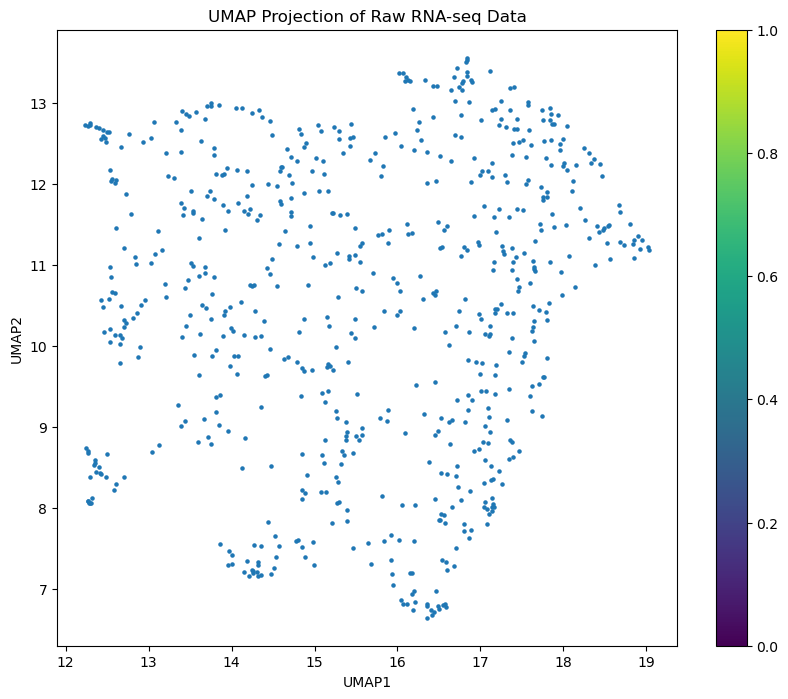

In [55]:
# Make UMAP of raw bulk RNA-seq data

import pandas as pd
import umap
import matplotlib.pyplot as plt

# Assuming scaled_out_df is your scaled DataFrame
# Use the DataFrame as is since 'stable_id' is the index
expression_data = counts_only_df

# Initialize the UMAP model
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')

# Fit and transform the data to get the UMAP representation
umap_embedding = reducer.fit_transform(expression_data)

# Create a DataFrame for the UMAP embedding
umap_df = pd.DataFrame(umap_embedding, index=counts_only_df.index, columns=['UMAP1', 'UMAP2'])

# Plot the UMAP representation
plt.figure(figsize=(10, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], s=5, cmap='Spectral')
plt.title('UMAP Projection of Raw RNA-seq Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar()
plt.show()


In [16]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def scale_data(out_df, scale=True):
    if scale:
        print('Scaling data..')
        
        # Check the shape of the data
        print(f'Original data shape: {out_df.shape}')
        
        # Initialize the scaler
        scaler = StandardScaler()
        
        # Fit the scaler on the data and transform
        out_df_scaled = scaler.fit_transform(out_df)
        
        # Convert the scaled data back to a DataFrame for easier verification
        out_df_scaled = pd.DataFrame(out_df_scaled, index=out_df.index, columns=out_df.columns)
        
        # Verify the scaling
        means = out_df_scaled.mean()
        stds = out_df_scaled.std()
        
        print(f'Scaled data mean (should be close to 0):\n{means.head()}')
        print(f'Scaled data std (should be close to 1):\n{stds.head()}')
        
        return out_df_scaled
    else:
        return out_df

# Example usage:
# Assuming out_df is your bulk RNA-seq data in a DataFrame format
scaled_out_df = scale_data(counts_only_df, scale=True)


Scaling data..
Original data shape: (707, 22810)
Scaled data mean (should be close to 0):
stable_id
ENSG00000000003   -7.851648e-18
ENSG00000000005   -3.346765e-16
ENSG00000000419   -4.067154e-17
ENSG00000000457    1.839249e-16
ENSG00000000460   -5.692445e-17
dtype: float64
Scaled data std (should be close to 1):
stable_id
ENSG00000000003    1.000708
ENSG00000000005    1.000708
ENSG00000000419    1.000708
ENSG00000000457    1.000708
ENSG00000000460    1.000708
dtype: float64


In [17]:
print(scaled_out_df)


stable_id  ENSG00000000003  ENSG00000000005  ENSG00000000419  ENSG00000000457  \
BA2392R           1.318824        -0.123395        -0.604989        -0.511886   
BA2611R           0.824273        -0.123395        -1.522052        -1.075507   
BA2506R           1.993211        -0.123395        -0.429219        -0.108360   
BA2430R           1.521140        -0.123395        -0.927872        -0.709263   
BA2448R           1.228905        -0.123395        -1.059700        -0.632505   
...                    ...              ...              ...              ...   
BA3385R          -0.322186        -0.123395        -0.014630         0.694305   
BA3242R          -0.457064        -0.123395        -0.543852         0.189898   
BA3446R          -0.389625        -0.123395         0.361747         0.505701   
BA3416R          -0.457064        -0.123395         1.001781         0.457453   
BA3123R          -0.389625        -0.123395        -0.475072         0.242532   

stable_id  ENSG00000000460 

/tmp/ipykernel_11590/4223889784.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], s=5, cmap='Spectral')


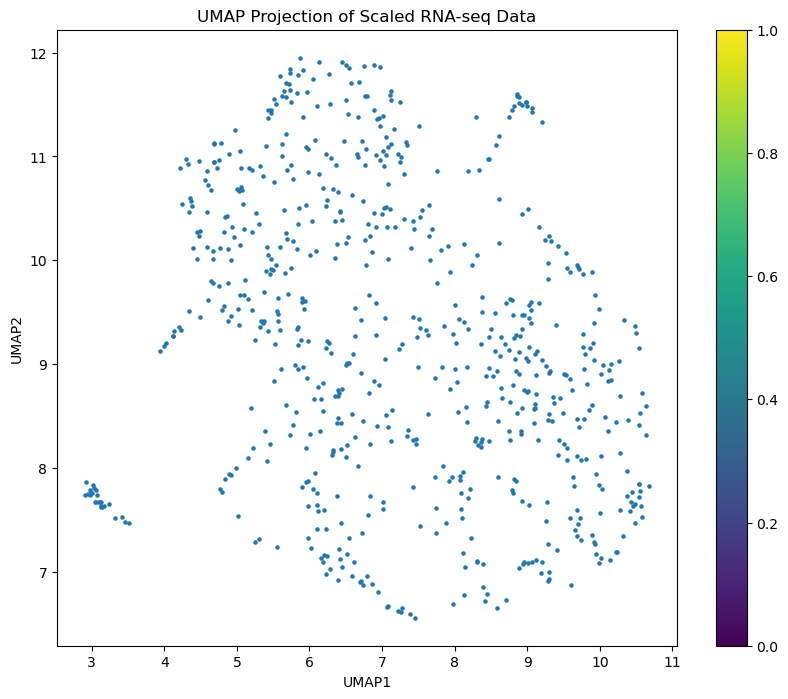

In [53]:
# Make UMAP of normalized/scaled bulk RNA-seq data

import pandas as pd
import umap
import matplotlib.pyplot as plt

# Assuming scaled_out_df is your scaled DataFrame
# Use the DataFrame as is since 'stable_id' is the index
expression_data = scaled_out_df

# Initialize the UMAP model
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')

# Fit and transform the data to get the UMAP representation
umap_embedding = reducer.fit_transform(expression_data)

# Create a DataFrame for the UMAP embedding
umap_df = pd.DataFrame(umap_embedding, index=scaled_out_df.index, columns=['UMAP1', 'UMAP2'])

# Plot the UMAP representation
plt.figure(figsize=(10, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], s=5, cmap='Spectral')
plt.title('UMAP Projection of Scaled RNA-seq Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar()
plt.show()



In [ ]:
'''
# Data is already TPM normalized, so I'm just selecting to scale in the below function
normalized_scaled_bulk_rna = preprocessing.preprocess_bulk_RNA(counts_only_df, normalize=False, scale=True)

print(normalized_scaled_bulk_rna)
#print(normalized_scaled_bulk_rna.loc[['13-00098', '19-00261']])
'''

In [17]:
# Select the top 2000 most variable genes in bulk RNA-seq data
#normalized_scaled_bulk_rna = utilities.select_top_variable_genes_bulk_rnaseq(normalized_scaled_bulk_rna, 2000)


In [18]:
# Save the above object to reduce the scRNA-seq data to the same variable features
import pickle

# Specify output directory for trained model pickle files
output_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'

# Save the data dictionary to a pickle file for downstream analysis
with open(output_dir + 'protein_coding_genes_bulk_rna_normed_scaled.pkl', 'wb') as f:
    pickle.dump(scaled_out_df, f)



In [41]:
 # Specify output directory for the .txt file
output_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'

# Save the scaled bulk data as a .txt file
scaled_out_df.to_csv(output_dir + 'protein_coding_genes_bulk_rna_normed_scaled.txt', sep='\t', index=True)


In [19]:
# Generate a list of known AML mutations to generate model-training sets for downstream use
'''
aml_genes = [
    'FLT3', 'NPM1', 'CEBPA', 'RUNX1', 'AML1', 'TP53', 'ASXL1',
    'DNMT3A', 'IDH1', 'IDH2', 'TET2', 'KIT', 'CD117', 'KRAS', 
    'NRAS', 'PTPN11', 'NF1', 'SRSF2', 'U2AF1', 'U2AF35', 'SF3B1', 
    'SF3A1', 'ZRSR2', 'RAD21', 'STAG1', 'STAG2', 'SMC3', 'NOTCH2', 
    'BCOR', 'BCORL1', 'WT1', 'PHF6', 'SH2B3', 'ATM', 'SETD2', 'GATA2'
]
'''

aml_genes = ['MAP4K5', 'CD117', 'EZH2', 'IDH2', 'SMC3', 'TET2', 'GATA2', 
             'RUNX1', 'NFIC', 'CUX1', 'NOTCH1', 'PTPN11', 'PRKDC', 'FLT3', 
             'SF3A1', 'SH2B3', 'NPM1', 'SRSF2', 'CWF19L2', 'U2AF1', 
             'ACAP2', 'NF1', 'AML1', 'PHF6', 'SMARCC1', 'SF3B1', 'CEBPA', 
             'SMARCD1', 'ASXL1', 'WT1', 'RAB9A', 'RAD21', 'FAM98C', 
             'DOLPP1', 'IDH1', 'U2AF35', 'STAG1', 'SETX', 'NOTCH2', 'RPS24', 
             'ZRSR2', 'KRAS', 'MTAP', 'SRSF2', 'BCORL1', 'DNMT3A', 'TP53', 
             'STAG2', 'BCOR', 'SETD2', 'MAP4K5', 'HNRNPUL1', 'ATM']



In [20]:
# Fetching Ensembl IDs
# NOTE: The following function defaults to the GRCh37 ENSEMBL human genome version, to change this, change the 
# server variable within the function.
gene_ids = utilities.fetch_ensembl_ids(aml_genes)
print(gene_ids)

# NOTE: Can also perform the following to fetch gene names from ENSEMBL IDs
#ensembl_ids = ['ENSG00000139618', 'ENSG00000240563', 'ENSG00000132854']
#gene_names = utilities.fetch_gene_names_from_ids(ensembl_ids)
#print(gene_names)

Fetching ENSEMBL ID for gene: 0 out of: 53
{'MAP4K5': 'ENSG00000012983', 'CD117': 'Error fetching ID', 'EZH2': 'ENSG00000106462', 'IDH2': 'ENSG00000182054', 'SMC3': 'ENSG00000108055', 'TET2': 'ENSG00000168769', 'GATA2': 'ENSG00000179348', 'RUNX1': 'ENSG00000159216', 'NFIC': 'ENSG00000141905', 'CUX1': 'ENSG00000257923', 'NOTCH1': 'ENSG00000148400', 'PTPN11': 'ENSG00000179295', 'PRKDC': 'ENSG00000253729', 'FLT3': 'ENSG00000122025', 'SF3A1': 'ENSG00000099995', 'SH2B3': 'ENSG00000111252', 'NPM1': 'ENSG00000181163', 'SRSF2': 'ENSG00000161547', 'CWF19L2': 'ENSG00000152404', 'U2AF1': 'ENSG00000160201', 'ACAP2': 'ENSG00000114331', 'NF1': 'ENSG00000196712', 'AML1': 'Error fetching ID', 'PHF6': 'ENSG00000156531', 'SMARCC1': 'ENSG00000173473', 'SF3B1': 'ENSG00000115524', 'CEBPA': 'ENSG00000245848', 'SMARCD1': 'ENSG00000066117', 'ASXL1': 'ENSG00000171456', 'WT1': 'ENSG00000184937', 'RAB9A': 'ENSG00000123595', 'RAD21': 'ENSG00000164754', 'FAM98C': 'ENSG00000130244', 'DOLPP1': 'ENSG00000167130', 'ID

#### Iterate through all the gene IDs and pull needed information from the dataframes

This step will create the variables needed to train the model(s)

In [21]:
normalized_scaled_bulk_rna = scaled_out_df


In [24]:
print(normalized_scaled_bulk_rna)
print(vcf_df['dbgap_sample_id'].unique())
print(len(vcf_df['dbgap_sample_id'].unique()))

#print(vcf_df['stable_id'].unique())
#print(len(vcf_df['stable_id'].unique()))


stable_id  ENSG00000000003  ENSG00000000005  ENSG00000000419  ENSG00000000457  \
BA2392R           1.318824        -0.123395        -0.604989        -0.511886   
BA2611R           0.824273        -0.123395        -1.522052        -1.075507   
BA2506R           1.993211        -0.123395        -0.429219        -0.108360   
BA2430R           1.521140        -0.123395        -0.927872        -0.709263   
BA2448R           1.228905        -0.123395        -1.059700        -0.632505   
...                    ...              ...              ...              ...   
BA3385R          -0.322186        -0.123395        -0.014630         0.694305   
BA3242R          -0.457064        -0.123395        -0.543852         0.189898   
BA3446R          -0.389625        -0.123395         0.361747         0.505701   
BA3416R          -0.457064        -0.123395         1.001781         0.457453   
BA3123R          -0.389625        -0.123395        -0.475072         0.242532   

stable_id  ENSG00000000460 

In [30]:
print(gene_ids)


{'MAP4K5': 'ENSG00000012983', 'CD117': 'Error fetching ID', 'EZH2': 'ENSG00000106462', 'IDH2': 'ENSG00000182054', 'SMC3': 'ENSG00000108055', 'TET2': 'ENSG00000168769', 'GATA2': 'ENSG00000179348', 'RUNX1': 'ENSG00000159216', 'NFIC': 'ENSG00000141905', 'CUX1': 'ENSG00000257923', 'NOTCH1': 'ENSG00000148400', 'PTPN11': 'ENSG00000179295', 'PRKDC': 'ENSG00000253729', 'FLT3': 'ENSG00000122025', 'SF3A1': 'ENSG00000099995', 'SH2B3': 'ENSG00000111252', 'NPM1': 'ENSG00000181163', 'SRSF2': 'ENSG00000161547', 'CWF19L2': 'ENSG00000152404', 'U2AF1': 'ENSG00000160201', 'ACAP2': 'ENSG00000114331', 'NF1': 'ENSG00000196712', 'AML1': 'Error fetching ID', 'PHF6': 'ENSG00000156531', 'SMARCC1': 'ENSG00000173473', 'SF3B1': 'ENSG00000115524', 'CEBPA': 'ENSG00000245848', 'SMARCD1': 'ENSG00000066117', 'ASXL1': 'ENSG00000171456', 'WT1': 'ENSG00000184937', 'RAB9A': 'ENSG00000123595', 'RAD21': 'ENSG00000164754', 'FAM98C': 'ENSG00000130244', 'DOLPP1': 'ENSG00000167130', 'IDH1': 'ENSG00000138413', 'U2AF35': 'Error fe

In [35]:
# Specify the model training dictionary to populate for later model training
model_training_df_dict = {}

# Select mutect or varscan depending on which genotyper you want to use
#genotyper = 'mutect'
#genotyper = 'varscan'

# Number of positive samples necessary
min_samps = 8

# Random seed to start
s = 0

# Iterate through the dictionary
for gene_name, gene_id in gene_ids.items():
    
    # Filter the dataframe to just the genes of interest
    filtered_df = vcf_df[vcf_df['gene'] == gene_id]
    
    # This is a way to drop duplicate samples in the dataset
    # Several of the variants were called for the same sample for both genotypers
    #filtered_df = filtered_df[filtered_df['genotyper'] == genotyper]
    
    # Extract unique original_ids from the given DataFrame
    # Gets all the sample IDs to pull from the RNA data
    #unique_sample_ids = filtered_df['original_id'].unique()
    unique_sample_ids = filtered_df['dbgap_sample_id'].unique()
        
    # Make sure we have the indices in the RNA-seq data
    #unique_sample_ids = [id for id in unique_sample_ids if id in normalized_scaled_bulk_rna.index]
    
    # Convert DNA sample IDs (BA****D) to RNA sample IDs (BA****R)
    unique_sample_ids = [id.replace('D', 'R') for id in unique_sample_ids if id.replace('D', 'R') in normalized_scaled_bulk_rna.index]
    
    # Check to make sure the resulting dataframe shape has 10 or more samples
    # This is to make sure we have adequate positive samples for training downstream
    if len(unique_sample_ids) >= min_samps:
        if gene_name not in model_training_df_dict.keys():
            model_training_df_dict[gene_name] = {}
            model_training_df_dict[gene_name]['gene_id'] = gene_id
        
        # Add the count of positive samples to the dictionary
        model_training_df_dict[gene_name]['positive_sample_count'] = len(unique_sample_ids)
 
        # Use these original_ids to filter the rows in the RNA-seq data
        # NOTE: This step takes a bit depending on how large your RNA-seq data is
        filtered_rna_seq_data = normalized_scaled_bulk_rna.loc[unique_sample_ids]
        
        # Add the sequencing data from the mutated samples to their own key
        model_training_df_dict[gene_name]['mut_sequencing_data'] = filtered_rna_seq_data
        
        # Randomly sample the same number of negative samples from the remaining RNA-seq data
        # Number of samples to draw, here I'm using the number of positive samples times 4
        num_samples = len(unique_sample_ids)

        # Update the random seed after each iteration
        # Can choose how to increment this number for a more "randomized", yet reproducible effect
        s += 1
        
        # Random seed for reproducibility
        random_seed = s

        # Get the sampled RNA-seq data
        sampled_rna_seq_data = utilities.sample_rna_seq_data(normalized_scaled_bulk_rna, unique_sample_ids, num_samples, random_seed)

        model_training_df_dict[gene_name]['non-mut_sequencing_data'] = sampled_rna_seq_data
        
        
        print(model_training_df_dict.keys())
        print(model_training_df_dict[gene_name].keys())
        
#print(model_training_df_dict)


dict_keys(['EZH2'])
dict_keys(['gene_id', 'positive_sample_count', 'mut_sequencing_data', 'non-mut_sequencing_data'])
dict_keys(['EZH2', 'IDH2'])
dict_keys(['gene_id', 'positive_sample_count', 'mut_sequencing_data', 'non-mut_sequencing_data'])
dict_keys(['EZH2', 'IDH2', 'SMC3'])
dict_keys(['gene_id', 'positive_sample_count', 'mut_sequencing_data', 'non-mut_sequencing_data'])
dict_keys(['EZH2', 'IDH2', 'SMC3', 'TET2'])
dict_keys(['gene_id', 'positive_sample_count', 'mut_sequencing_data', 'non-mut_sequencing_data'])
dict_keys(['EZH2', 'IDH2', 'SMC3', 'TET2', 'GATA2'])
dict_keys(['gene_id', 'positive_sample_count', 'mut_sequencing_data', 'non-mut_sequencing_data'])
dict_keys(['EZH2', 'IDH2', 'SMC3', 'TET2', 'GATA2', 'RUNX1'])
dict_keys(['gene_id', 'positive_sample_count', 'mut_sequencing_data', 'non-mut_sequencing_data'])
dict_keys(['EZH2', 'IDH2', 'SMC3', 'TET2', 'GATA2', 'RUNX1', 'PTPN11'])
dict_keys(['gene_id', 'positive_sample_count', 'mut_sequencing_data', 'non-mut_sequencing_data'])

In [36]:
# Check how many positive samples there are for each gene classification
for key, value in model_training_df_dict.items():
    print(key)
    
    if 'positive_sample_count' in model_training_df_dict[key].keys():
        print(model_training_df_dict[key]['positive_sample_count'])


EZH2
19
IDH2
73
SMC3
10
TET2
82
GATA2
29
RUNX1
75
PTPN11
32
FLT3
67
NPM1
141
SRSF2
72
U2AF1
32
NF1
16
SF3B1
35
CEBPA
37
ASXL1
63
WT1
47
RAD21
15
IDH1
49
KRAS
34
DNMT3A
138
TP53
57


#### Train the classification models using the data in the gene dictionary

In [37]:
# Specify output directory for trained model pickle files
output_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/'


In [38]:
import pickle

# Save the data dictionary to a pickle file for downstream analysis
with open(output_dir + 'model_training_dictionary_correct_preprocessing_bulk_rna.pkl', 'wb') as f:
    pickle.dump(model_training_df_dict, f)


In [39]:
models.logistic_ridge_regression(model_training_df_dict, output_dir, test_size=0.10)


Trained and saved model for gene: EZH2 as EZH2_logistic_ridge_model.pkl
Training set size: 34, Test set size: 4
Evaluation for gene: EZH2
Accuracy: 0.75
Precision: 0.6666666666666666
Recall: 1.0
F1 Score: 0.8
Confusion Matrix:
[[1 1]
 [0 2]]
Trained and saved model for gene: IDH2 as IDH2_logistic_ridge_model.pkl
Training set size: 131, Test set size: 15
Evaluation for gene: IDH2
Accuracy: 0.8
Precision: 0.7272727272727273
Recall: 1.0
F1 Score: 0.8421052631578947
Confusion Matrix:
[[4 3]
 [0 8]]
Trained and saved model for gene: SMC3 as SMC3_logistic_ridge_model.pkl
Training set size: 18, Test set size: 2
Evaluation for gene: SMC3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[0 1]
 [1 0]]
Trained and saved model for gene: TET2 as TET2_logistic_ridge_model.pkl
Training set size: 147, Test set size: 17
Evaluation for gene: TET2
Accuracy: 0.7058823529411765
Precision: 0.6363636363636364
Recall: 0.875
F1 Score: 0.7368421052631579
Confusion Matrix:
[[5 4]
 [1 7]]

/home/groups/precepts/ashforda/anaconda3/envs/scOPE_working_environment/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/groups/precepts/ashforda/anaconda3/envs/scOPE_working_environment/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/groups/precepts/ashforda/anaconda3/envs/scOPE_working_environment/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` 

Evaluation for gene: RAD21
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[3]]
Trained and saved model for gene: IDH1 as IDH1_logistic_ridge_model.pkl
Training set size: 88, Test set size: 10
Evaluation for gene: IDH1
Accuracy: 0.9
Precision: 0.8333333333333334
Recall: 1.0
F1 Score: 0.9090909090909091
Confusion Matrix:
[[4 1]
 [0 5]]
Trained and saved model for gene: KRAS as KRAS_logistic_ridge_model.pkl
Training set size: 61, Test set size: 7
Evaluation for gene: KRAS
Accuracy: 0.7142857142857143
Precision: 0.75
Recall: 0.75
F1 Score: 0.75
Confusion Matrix:
[[2 1]
 [1 3]]
Trained and saved model for gene: DNMT3A as DNMT3A_logistic_ridge_model.pkl
Training set size: 248, Test set size: 28
Evaluation for gene: DNMT3A
Accuracy: 0.6071428571428571
Precision: 0.5
Recall: 0.2727272727272727
F1 Score: 0.35294117647058826
Confusion Matrix:
[[14  3]
 [ 8  3]]
Trained and saved model for gene: TP53 as TP53_logistic_ridge_model.pkl
Training set size: 102, Test set size

In [51]:
models.random_forest_classification(model_training_df_dict, output_dir, test_size=0.10)


KeyboardInterrupt: 